In [1]:
#Placeholder for equations
d_prime = d_0 + m_d * (t - t_0)
a_prime = a_0 + m_a * (t - t_0) / (np.cos(d_prime))

a_t = a_prime + (p * (x * np.sin(a_prime) - y * np.cos(a_prime)) / np.cos(d_prime))
d_t = d_prime + (p * (x * np.cos(a_prime) * np.sin(d_prime) + (y * np.sin(a_prime) * np.sin(d_prime))) + (z * np.cos(d_prime)))

NameError: name 'd_0' is not defined

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import math
from astropy.time import Time
from astropy.io import ascii
import astropy
import seaborn as sns
import os
from decimal import *
from PyAstronomy import pyasl

import time


WISE = dict() #key: number, values: a_0, d_0, mu_a, mu_d, pi_trig, mu_a_min, mu_a_max, mu_d_min, mu_d_max, pi_trig_min, pi_trig_max
WISE['0825+2805'] = [126.3 * 3600, 28.1 * 3600, -0.0644, -0.2347, 0.1390, -0.06988, -0.05882, -0.24009, -0.22937, 0.13469, 0.14335]
WISE['1738+2732'] = [264.6 * 3600, 27.5 * 3600, 0.3433, -0.3406, 0.1363, 0.33982, 0.34672, -0.3498, -0.33728, 0.13199, 0.14053]
WISE['0336-0143'] = [54.0 * 3600, -1.7 * 3600, -0.2474, -1.2135, 0.1009, -0.2534, -0.2413, -1.21953, -1.20747, 0.09504, 0.10676]
WISE['2209+2711'] = [332.3 * 3600, 27.2 * 3600, 1.1996, -1.3590, 0.1544, 1.19461, 1.20449, -1.36376, -1.35424, 0.14874, 0.16008]

C:\Users\judah\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
C:\Users\judah\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Text(0.5, 1.0, 'finding range of theta max for microlensing')

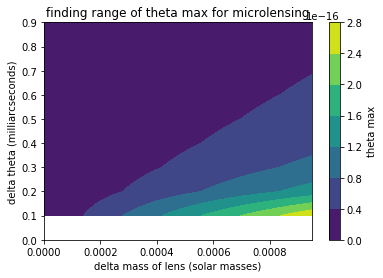

In [3]:
#before we start, I need to find a good reference for maximum theta for microlensing

x = np.arange(0, 9.548 * math.pow(10, -4), 0.00001) #solar mass of jupiter as maximum
y = np.arange(0, 1, 0.1)
xx, yy = np.meshgrid(x, y, sparse=True)

#constants
big_g = 4.3 * math.pow(10, -3) #pc * solar_mass^-1 * (km/s)^2
c_squared = 2.997 * math.pow(10, 10) #(km/s)^2
d_l = 20 #parsecs, picked largest value for smallest theta_max and most certainty of lensing event

z = (4 * big_g * xx) / (c_squared * d_l * yy)

h = plt.contourf(x,y,z)

colorbar = plt.colorbar(h)
colorbar.set_label('theta max')

plt.xlabel('delta mass of lens (solar masses)')
plt.ylabel('delta theta (milliarcseconds)')
plt.title('finding range of theta max for microlensing')

#looks like the max for theta max under these circumstances is 1.05

In [4]:
#now all below is plotting and finding targets for the brown dwarfs

#make x,y,z readable for smaller years
def parse_small(file):
    eph = open(file, 'r')
    eph_l = list()
    eph_l_2 = list()
    eph_dict = dict()
    eph_dict_2 = dict()
    
    for i in eph.readlines():
        eph_l.append(i.rstrip())

    for i in range(len(eph_l)):
        if "X =" in eph_l[i]:
            eph_dict[eph_l[i-1]] = eph_l[i]      
            
    for i in eph_dict:
        a = i.split(' ')
        a = a[0]
        eph_dict_2[a] = eph_dict[i]
    
    for i in eph_dict_2:
        #getting value in eph_dict_2 to be list of x,y,z
        eph_dict_2[i] = eph_dict_2[i].replace('X', '')
        eph_dict_2[i] = eph_dict_2[i].replace('Y', '')
        eph_dict_2[i] = eph_dict_2[i].replace('Z', '')
        eph_dict_2[i] = eph_dict_2[i].replace('=', '')
        eph_dict_2[i] = eph_dict_2[i].split()

        for x in range(len(eph_dict_2[i])):
            eph_dict_2[i][x] = float(eph_dict_2[i][x])
        
    eph.close()
    return eph_dict_2

#make x,y,z readable for larger years
def parse_large(file):
    eph = open(file, 'r')
    eph_l = list()
    eph_l_2 = list()
    eph_l_3 = list()
    eph_dict = dict()
    
    for i in eph.readlines():
        eph_l.append(i.rstrip())
        
    SOE = False #getting just values and dates from file
    for i in eph_l:
        if i == '$$EOE':
            SOE = False
        if SOE == True:
            eph_l_3.append(i)
        if i == '$$SOE':
            SOE = True

    for i in eph_l_3:
        sublist = list()
        a = i.split(',')
        a = ''.join(a)
        a = a.split(' ')
        for x in a:
            try:
                if x.isdigit and float(x) > 10000:
                    b = x
                if x.isdigit and float(x) < 10000:
                    sublist.append(float(x))
            except:
                True
        
        eph_dict[b] = sublist
    
    eph.close()
    return eph_dict

eph_dict_3 = parse_large('horizons_results_50.txt')

In [5]:
def number_only(string):
    string = string.replace(" ", "")
    
    for i in range(len(string)):
        try:
            float(string)
            return string
        except:
            return number_only(string[:len(string) - 1])

In [6]:
#creating list of tuples containing coord in ephemerides, a_t, d_t to plot in plot_list function
def path_list(star_data, eph_dict):
    place_l = list()
    coord_dict = dict()

    a_0 = star_data[1] * 3600
    d_0 = star_data[2] * 3600
    pi_trig = float(number_only(star_data[3])) / 1000
    mu_a = float(number_only(star_data[4])) / 1000
    mu_d = float(number_only(star_data[5])) / 1000
    t_0 = 2014.0 #when observations happened
    
    for coord in eph_dict:
        #converting coord to year
        t = Time(float(coord), format='jd')
        t.format = 'jyear'
        t = t.value

        d_prime = d_0 + (mu_d * (t - t_0))
        #converting d to rad
        d_prime_r = d_prime / 206265

        a_prime = a_0 + (mu_a * (t - t_0) / (np.cos(d_prime_r)))
        #convert a to rad
        a_prime_r = float(a_prime / 206265)

        a_t = a_prime + ((pi_trig * ((eph_dict[coord][0] * np.sin(a_prime_r)) - (eph_dict[coord][1] * np.cos(a_prime_r))) / np.cos(d_prime_r)))
        d_t = d_prime + (pi_trig * ((eph_dict[coord][0] * np.cos(a_prime_r) * np.cos(d_prime_r)) + (eph_dict[coord][1] * np.sin(a_prime_r) * np.sin(d_prime_r)) - (eph_dict[coord][2] * np.cos(d_prime_r))))

        #convert a_t and d_t to degrees
        a_t = a_t / 3600
        d_t = d_t / 3600

        coord_dict[t] = [a_t, d_t]
    
    #find list of alpha and dec to find the end points (for graphing purposes)
    a_list = list()
    d_list = list()
    for i in coord_dict:
        a_list.append(coord_dict[i][0])
        d_list.append(coord_dict[i][1])
    plt.scatter(a_list, d_list, s=0.5)

    a_ends = [list(coord_dict.values())[0][0], list(coord_dict.values())[len(a_list) - 1][0]]
    d_ends = [list(coord_dict.values())[0][1], list(coord_dict.values())[len(a_list) - 1][1]]
    
    mag_mu = math.sqrt((math.pow(mu_a, 2) + math.pow(mu_d, 2)))

    return coord_dict, a_ends, d_ends, mag_mu

In [7]:
#filter out stars dont know mag_r of
def filter_stars(stars):
    mags = list()
    
    #filtering NaN, Infinity, and 0<=star<=30 values
    df = pd.DataFrame(stars)
    
    df = df.replace('Infinity', np.nan) #replace infinities with nan
    df = df.dropna(subset=['dered_mag_r']) #drop nan
    
    df['dered_mag_r'] = pd.to_numeric(df['dered_mag_r'])
    
    df = df[df.dered_mag_r >= 0]
    df= df[df.dered_mag_r <= 30]

    return df

def star_mag_r(stars):
    mags = list()
    
    #filtering NaN, Infinity, and 0<=star<=30 values
    df = pd.DataFrame(stars)
    df = df.replace('Infinity', np.nan) #replace infinities with nan
    df = df.dropna(subset=['dered_mag_r']) #drop nan
    
    df['dered_mag_r'] = pd.to_numeric(df['dered_mag_r'])
    
    df = df[df.dered_mag_r >= 0]
    df = df[df.dered_mag_r <= 30]

    df1 = df['dered_mag_r']
    
    return df1

#filter to only stars
def star_filter(dataset):
    drop_l = list()
    for i in range(len(dataset['type'])):
        if dataset['type'][i] != 'PSF':
            drop_l.append(i)

    return dataset.drop(drop_l, axis=0)

In [8]:
#calculate theta max for a given parallax for each brown dwarf
def theta_max_calc(star_data):
    #get parallax and astrometric precision
    point = 0
    parallax = star_data[3]
    for i in range(len(parallax)):
        if parallax[i] == ' ':
            point = i
            break
    parallax = float(parallax[:point]) / 1000 #convert from mas to arcseconds         

    #astro_precision = float(parallax[(point + 6):]) #in milliarcseconds
    #astro_precision = 0.05 #cushings example
    astro_precision = 0.005 #gaia potential precision

    #constants
    big_g = 4.3 * math.pow(10, -3) #pc * solar_mass^-1 * (km/s)^2
    c_squared = (2.997 * math.pow(10, 5)) ** 2 #(km/s)^2
    d_l = (1 / parallax) #in parsecs
    delta_ml = 4 * 9.548 * math.pow(10, -4) #mass of jupiter -- what would like (changed to 4 Mjup for test)
    #delta_ml = 0.1 #cushing's example
    k = 8.144 #mas/solar masses
    
    theta_max = (k * delta_ml * parallax) / (astro_precision)
    #theta_max = (4 * big_g * delta_ml) / (c_squared * d_l * astro_precision)

    return theta_max

In [9]:
def delta_ml_calc(star_data, theta):
    #get parallax and astrometric precision
    point = 0
    parallax = star_data[3]
    for i in range(len(parallax)):
        if parallax[i] == ' ':
            point = i
            break 
    parallax = float(parallax[:point]) / 1000 #convert from mas to arcseconds
    
    astro_precision = 0.005 #gaia potential precision
    k = 8.144 #mas/solar masses
    
    delta_ml = (theta * astro_precision) / (k * parallax)
    
    delta_ml = delta_ml / (9.548 * math.pow(10, -4)) #making into jupiter masses
    
    return delta_ml

In [10]:
def events_per_year_calc(star_data, eph):
    #calculate the number of expected microlensing events per year for a given brown dwarf
    k = 8.144 #mas/solar masses

    #get parallax and astrometric precision
    point = 0
    parallax = star_data[3]
    for i in range(len(parallax)):
        if parallax[i] == ' ':
            point = i
            break    
    #astro_precision = float(parallax[(point + 6):]) #in milliabrcseconds
    astro_precision2 = 0.05 #cushing's example
    astro_precision = 0.005 #gaia potential precision
    parallax = float(parallax[:point]) / 1000 #convert from mas to arcseconds
    
    mu_a = float(number_only(star_data[4]))
    mu_d = float(number_only(star_data[5]))
    mu = math.sqrt((mu_a ** 2) + (mu_d ** 2))
    
    sigma = len(eph) / (np.pi * ((5 * 60) ** 2)) #the surface density of stars per arcsecond^2 (#stars / area of view with radius 5 degrees)
    delta_ml = 4 * 9.548 * math.pow(10, -4) #solar mass of jupiter -- what would like (changed to 4 Mjup for test)
    delta_ml2 = 0.1 #cushings example
    
    number = 2 * k * parallax * sigma * (delta_ml / astro_precision)
    number2 = 2 * k * parallax * sigma * (delta_ml2 / astro_precision2)
    
    return number

In [11]:
def close_star_find(eph, path_dict, a_ends, d_ends, star_data, theta_max, radius):
    #to save time, run through brown dwarf if close to star path
    a_low = a_ends[0] - (radius * abs(a_ends[1] - a_ends[0]))
    a_high = a_ends[1] + (radius * abs(a_ends[1] - a_ends[0]))
    d_low = d_ends[0] - (radius * abs(d_ends[1] - d_ends[0]))
    d_high = d_ends[1] + (radius * abs(d_ends[1] - d_ends[0]))

    full_close_dict = dict()
    #add all stars and theta_min to dictionary and process afterwards
    for i in range(len(eph['decals_id'])): #run through each background star
        #print(a_low, a_high, d_low, d_high, abs(eph.iloc[i,1]), abs(eph.iloc[i,2]))
        if eph.iloc[i,1] > a_low and eph.iloc[i,1] < a_high and eph.iloc[i,2] > d_low and eph.iloc[i,2] < d_high:
            theta_min = 1000
            
            for j in path_dict: #run through each brown dwarf data point in path
                a_1 = path_dict[j][0] #* 2 * np.pi * (1 / 360) #brown dwarf alpha converted to rad
                d_1 = path_dict[j][1] #* 2 * np.pi * (1 / 360) #brown dwarf dec converted to rad
                a_2 = eph.iloc[i, 1] #* 2 * np.pi * (1 / 360) #obj alpha converted to rad
                d_2 = eph.iloc[i, 2] #* 2 * np.pi * (1 / 360) #obj dec converted to rad

                theta_a = a_1 - a_2 #difference in alpha between brown dwarf and background obj
                theta_d = d_1 - d_2 #difference in dec between brown dwarf and backgroun obj
                theta = pyasl.getAngDist(a_1, d_1, a_2, d_2) #angular difference in degrees
                theta = theta * (2 * np.pi * (1 / 360)) * 206264 #convert from radians to arcseconds

                if theta < theta_min:
                    theta_min = theta
                    time_of_min = j

                    background_star_id = eph.iloc[i][0]
                    background_star_mag = eph.iloc[i][4] #dered_mag_r
                    background_star_ra = eph.iloc[i][1]
                    background_star_dec = eph.iloc[i][2]
                    background_star_gaia_flag = eph.iloc[i][11]
            """
            if within_max_candidate is True:
                within_max_dict[theta_id] = [theta_max, theta_min, star_data[0], time2]
            within_max_candidate = None
            """
            delta_ml = delta_ml_calc(star_data = star_data, theta = theta_min)
            full_close_dict[background_star_id] = [star_data[0], theta_max, theta_min, time_of_min, delta_ml, background_star_ra, background_star_dec, background_star_mag, background_star_gaia_flag]
      
    #cut full_close_dict -- keep within theta_max and keep closest stars if no inside theta_max
    cut_close_dict = dict()
    under_consideration = None
    theta_max_check = False
    for i in range(len(full_close_dict)):
        key = list(full_close_dict.keys())[i]
        key_minus_one = list(full_close_dict.keys())[i-1]
        
        #add to cut_close_dict if within parameters
        if full_close_dict[key][2] < full_close_dict[key][1]:
            #show code that there is a star within max
            theta_max_check = True
            under_consideration = None
            
            #add to cut_close_dict (probably an easier way than manually creating a new key/value pair, but just did it that way bc easiest)
            cut_close_dict[key] = [full_close_dict[key][0], full_close_dict[key][1], full_close_dict[key][2], full_close_dict[key][3], full_close_dict[key][4], full_close_dict[key][5], full_close_dict[key][6], full_close_dict[key][7], full_close_dict[key][8]]
        
        elif theta_max_check == False and under_consideration is None:
            under_consideration = [key, full_close_dict[key][0], full_close_dict[key][1], full_close_dict[key][2], full_close_dict[key][3], full_close_dict[key][4], full_close_dict[key][5], full_close_dict[key][6], full_close_dict[key][7], full_close_dict[key][8]]
        
        elif theta_max_check == False:
            #if this background star is less than the one under consideration
            if full_close_dict[key][2] < under_consideration[3]:
                under_consideration = [key, full_close_dict[key][0], full_close_dict[key][1], full_close_dict[key][2], full_close_dict[key][3], full_close_dict[key][4], full_close_dict[key][5], full_close_dict[key][6], full_close_dict[key][7], full_close_dict[key][8]]
   
    #after going through, if no theta under theta_max found, then add smallest
    if under_consideration is not None:
            cut_close_dict[under_consideration[0]] = [under_consideration[1], under_consideration[2], under_consideration[3], under_consideration[4], under_consideration[5], under_consideration[6], under_consideration[7], under_consideration[8], under_consideration[9]] 
    #print(cut_close_dict)     
    return cut_close_dict

In [29]:
#function to find the minimum theta and its characteristics
def close_stars(eph, path_dict, a_ends, d_ends, star_data, theta_max):
    #variability of lengths of star paths makes the process below unneeded -- it also is unfinished.
    """
    #filter out stars not within ends of ra and dec +-0.3 change of ra and dec
    a_change = a_ends[1] - a_ends[0]
    a_high = a_ends[1] + (0.3 * a_change)
    a_low = a_ends[0] + (0.3 * a_change)
    
    d_change = d_ends[1] - d_ends[0]
    d_high = d_ends[1] + (0.3 * d_change)
    d_low = d_ends[0] + (0.3 * d_change)
    
    print('len before: ', len(eph['decals_id']))
    drop_list = list()
    for i in range(len(eph['decals_id'])):
        ra = eph.iloc[i, 1] #ra for each background star
        dec = eph.iloc[i, 2] #dec for each background star
        if not ((ra < a_high and ra > a_low) and (dec < d_high and dec > d_low)): #if outside set boundaries
            drop_list.append(i)
    eph.drop(eph.index[drop_list])
    print('len after: ', len(eph['decals_id']))
    """
    
    #continually increase the radius until hit more stars. makes sure get closest star in each while still keeping processing low
    cut_close_dict = {}
    radius = 0
    while len(cut_close_dict.keys()) == 0:
        radius += 0.5
        cut_close_dict = close_star_find(eph = eph, path_dict = path_dict, a_ends = a_ends, d_ends = d_ends, star_data = star_data, theta_max = theta_max, radius = radius)
        
        if radius == 20: #semi-random stopping point
            break
    
    print(radius)   
    return cut_close_dict#, within_max_dict

In [13]:
#Reading and formatting ascii table to desired format
candidate_stars = ascii.read('apjsaaf6aft4_ascii.txt', format='tab')
candidate_stars.keep_columns(['(1)', '(2)', '(4)', '(6)', '(8)', '(9)'])

candidate_stars.rename_column('(1)', 'object_name')
candidate_stars.rename_column('(2)', 'J2000_ra')
candidate_stars.rename_column('(4)', 'J2000_dec')
candidate_stars.rename_column('(6)', 'pi_abs')
candidate_stars.rename_column('(8)', 'mu_ra')
candidate_stars.rename_column('(9)', 'mu_dec')

#stars decals that had nearby ephemerides
eph_list = ['2MASS 0034+0523', 'WISE 0038+2758', 'WISE 0049+2151', 'CFBDS 0133+0231', 'WISE 0226-0211AB', 'WISE 0336-0143', 'WISE 0825+2805', 'WISE 0833+0052', 'WISE 0855-0714', 'WISE 0952+1955', 'WISE 1025+0307', 'ULAS 1043+1048', 'WISE 1124-0421', 'ULAS 1152+1134', 'WISE 1217+1626AB', 'WISE 1225-1013', '2MASS 1231+0847', 'WISE 1254-0728', 'WISE 1301-0302', 'VHS 1433-0837', 'WISE 1517+0529', 'WISE 1523+3125', 'WISE 1542+2230', 'WISE 1614+1739', '2MASS 1615+1340', 'WISE 1721+1117', 'WISE 1738+2732', 'WISE 1804+3117', 'WISE 1812+2007', 'WISE 1813+2835', 'WISE 2147-1029', 'WISE 2157+2659', 'WISE 2209+2711', 'WISE 2301+0216', 'WISE 2319-1844', 'ULAS 2321+1354', 'ULAS 2326+0201', 'WISE 2344+1034', 'WISE 2354+0240', 'WISE 2357+1227']

#keep rows with stars with nearby ephemerides
#needs copy to preserve length of table in for loop
candidate_stars_2 = candidate_stars.copy()
#need different list because .index() cannot do masked columns -- adds lots of unfortunate complexity
candidate_stars_2_o = list(candidate_stars_2['object_name'])
for i in candidate_stars['object_name']:
    if i not in eph_list:
        obj_index = candidate_stars_2_o.index(i)
        candidate_stars_2.remove_row(obj_index)
        candidate_stars_2_o.remove(i)
        
candidate_stars = candidate_stars_2

In [30]:
#actual plotting
count = 0
close_dict = dict()
within_max_dict = dict()

with sns.axes_style('darkgrid', {'xtick.bottom': True, 'ytick.left': True}):
    sns.set_context('paper')

    for filename in os.listdir(r'C:\Users\judah\candidate_stars_ephemerides'):
        coord_dict, a_ends, d_ends, mag_mu = path_list(star_data = candidate_stars[count], eph_dict = eph_dict_3)
        #find star name
        filename_cut = filename[:8]

        #horiz = int(count % 4)
        #vert = int((count - horiz) / 4)
        
        
        #find list of alpha and dec for scatter plot and then plot
        a_list = list()
        d_list = list()
        for i in coord_dict:
            a_list.append(coord_dict[i][0])
            d_list.append(coord_dict[i][1])
        plt.scatter(a_list, d_list, s=0.5)

        
        #add stars into scatter plot
        full_filename = 'C:\\Users\\judah\\candidate_stars_ephemerides\\' + filename
        
        ephemerides = pd.read_csv(full_filename)
        ephemerides = star_filter(ephemerides)
        ephemerides = filter_stars(ephemerides)
        
        eph_plot = plt.scatter(filter_stars(ephemerides).ra, filter_stars(ephemerides).dec, s = star_mag_r(ephemerides), c = star_mag_r(ephemerides), cmap = 'viridis')
        eph_colorbar = plt.colorbar(eph_plot)
        eph_colorbar.set_label('Ephemeris Mag')
        
        
        #general formatting
        plt.title(filename_cut + '; 2019 - 2069; mag_μ: ' + str(mag_mu))
        plt.xlabel('RA (deg)')
        plt.ylabel('Dec (deg)')
        #set limits +-200% change in alpha/dec
        plt.xlim(a_ends[0] - (2 * (a_ends[1] - a_ends[0])), a_ends[1] + (2 * (a_ends[1] - a_ends[0])))
        plt.ylim(d_ends[0] - (2 * (d_ends[1] - d_ends[0])), d_ends[1] + (2 * (d_ends[1] - d_ends[0])))
        
        
        #make list of alpha and dec every 10 years and plot them with text as visual markers
        year_list_a = list()
        year_list_d = list()
        count2 = 0
        for i in range(len(a_list)):
            count2 += 1
            if count2 % 120 == 0:
                year_list_a.append(a_list[i])
                year_list_d.append(d_list[i])
                
        plt.scatter(year_list_a, year_list_d, s=5, marker="D")
        
        #adding text to 10 yr plot
        #finding placement to put plots
        delta_a = (a_ends[1] - a_ends[0]) * 0.1
        delta_d = (d_ends[1] - d_ends[0]) * 0.01
        
        count2 = 0
        for i in range(len(year_list_a)):
            count2 += 10
            plt.text(year_list_a[i] - delta_a, year_list_d[i] + delta_d, count2)

        print('Created plot for', filename_cut)
        
        plt.savefig(r'C:\\Users\\judah\\candidate_stars_plots\\' + filename_cut)
        
        #find which ephemerides are closest to the path
        theta_max = theta_max_calc(star_data = candidate_stars[count])
        events_per_year = events_per_year_calc(star_data = candidate_stars[count], eph = ephemerides)

        temp_close_dict = close_stars(eph = ephemerides, path_dict = coord_dict, a_ends = a_ends, d_ends = d_ends, star_data = candidate_stars[count], theta_max = theta_max)
        close_dict.update(temp_close_dict)
        #within_max_dict.update(temp_within_max_dict)
        
        plt.clf()
        count += 1

Created plot for 0034+052
0.5
Created plot for 0038+275
3.5
Created plot for 0049+215
2.5
Created plot for 0133+023
1.5
Created plot for 0226-021
1.0
Created plot for 0336-014
1.0
Created plot for 0825+280
2.5
Created plot for 0833+005
1.0
Created plot for 0855-071
1.0
Created plot for 0952+195
1.5
Created plot for 1025+030
1.0
Created plot for 1043+104
1.0
Created plot for 1124-042
1.5
Created plot for 1152+113
2.5
Created plot for 1217+162
1.0
Created plot for 1225-101
6.0
Created plot for 1231+084
1.0
Created plot for 1254-072
6.0
Created plot for 1301-030
1.0
Created plot for 1433-083
1.5
Created plot for 1517+052
1.5
Created plot for 1523+312
1.0
Created plot for 1542+223
1.0
Created plot for 1614+173
1.0
Created plot for 1615+134
1.0
Created plot for 1721+111
1.0
Created plot for 1738+273
1.0
Created plot for 1804+311
6.5
Created plot for 1812+200
20.0
Created plot for 1813+283
1.5
Created plot for 2147-102
20.0
Created plot for 2157+265
1.5
Created plot for 2209+271
1.0
Created 

<Figure size 432x288 with 0 Axes>

In [32]:
#check if it worked
print(len(close_dict))
print(len(candidate_stars['object_name']))

#it worked! there are 7 extra events at a mjup of 4. Two candidates also did not have any non infinite magnitudes

45
40


In [71]:
#make table of data
#format data into pandas readable form
df_array = list()
for i in close_dict:
    df_array.append([close_dict[i][0], close_dict[i][1], close_dict[i][4], i, close_dict[i][3], close_dict[i][5], close_dict[i][6], close_dict[i][7], close_dict[i][8]])

df = pd.DataFrame(df_array, columns = ['star', 'minimum_theta_predicted (arcseconds)', 'delta_ml_for_theta (Mjup)', 'background_id', 'time_of_minimum', 'background_ra (arcseconds)', 'background_dec (arcseconds)', 'background_mag', 'gaia_pointsource'])

#make background_id into string so no formatting done
df = df.applymap(str)

df

,star,minimum_theta_predicted (arcseconds),delta_ml_for_theta (Mjup),background_id,time_of_minimum,background_ra (arcseconds),background_dec (arcseconds),background_mag,gaia_pointsource
0,2MASS 0034+0523,0.747107626496,16.86878296470569,7696605122134218,2019.2950034223136,8.717560422371559,5.385438143928241,25.7567,0
1,WISE 0038+2758,0.557997952512,119.48294592620151,7696613219501656,2019.2950034223136,9.62028692602925,27.9767252794591,21.5437,1
2,WISE 0049+2151,0.8702777431040001,13.222604884053357,7696611075033184,2023.7138945927447,12.438266632904801,21.8561006680502,18.506,0
3,CFBDS 0133+0231,0.350226139648,62.16396135979816,7696603995246790,2052.715947980835,23.2676546679918,2.5248191837458998,23.4689,0
4,WISE 0226-0211AB,0.35644685260799996,39.12758265607513,7696602205655239,2062.4626967830254,36.5965234163778,-2.20193145121306,24.859,0
5,WISE 0336-0143,0.6158505830400001,19.35670228716716,7696602398984212,2031.6290212183435,54.02040590865211,-1.7383610153975702,22.7682,0
6,WISE 0825+2805,0.9691870791680001,29.0899571311459,7696613246504155,2019.2950034223136,126.27826528326901,28.0967460932362,23.0283,0
7,WISE 0833+0052,0.513830890496,22.29151414859481,7696603362169661,2023.7960301163587,128.411337712173,0.8651065592856979,20.9983,1
8,WISE 0855-0714,2.7302709181439995,3.474475695678062,7696600349215614,2040.0479123887749,133.727739518255,-7.240132711453719,22.9674,0
9,WISE 0855-0714,2.7302709181439995,0.4694400033633801,7696600349215571,2027.1334702258728,133.75709531684998,-7.24183164182705,23.6295,0


In [72]:
df.to_csv('microlensing_table.csv', index = False)